#Audio-to-Audio Summarization Group Project

####Safari Browser Compatibility Issues

**Overview**

Our project experiences functionality issues on Safari due to its limited JavaScript handling, particularly affecting file uploads in Google Colab.

**Cause**

Safari's JavaScript engine cannot handle the complexity required by our interactive notebooks, leading to errors like MessageError: RangeError: Maximum call stack size exceeded.

**Recommendations**
- Use Alternate Browser (Google/Edge/Firefox): These browsers offer better compatibility with Google Colab.
- Opt for a Local Setup: Running Jupyter notebooks locally avoids browser limitations and improves performance.

For optimal performance, avoid using Safari for this project due to its JavaScript constraints.

##Introduction
Text summarization is a method that presents a condensed version of one or more texts with semantics (Gupta & Lehal, 2010), while audio summarization offers audiences the convenience of listening to an audio summary rather than reading a text summary (Vartakavi et al., 2021). In this project, we focus on audio-to-audio summarization using audio as inputs to summarize the content into shorter versions while not losing much emotion information. Our primary objective is to identify the best-performing model for audio-to-audio summarization among the explored models. This technique will potentially enhance businesses efficiency and broaden accessibility, benefiting diverse audiences such as individuals with visual impairments, thereby making it applicable for daily use across various scenarios.

##Data Preparation
The data input for this project consists of three audio mp3s. Each audio provides a different emotion, as can be seen in table below.

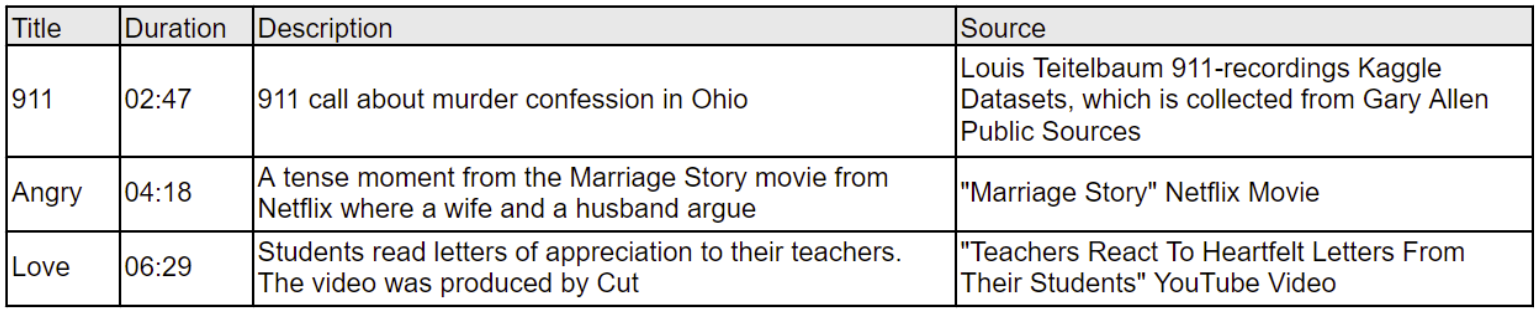

The selection of audio is based on the representation of different emotions, offering various sentiments to be analyzed in the project, while the 911 audio is used to train the model with noisy audio. After the audio is inputted, for the first part of the project, we convert mp3 audio to WAV audio for further analysis.

## Install Necessary Packages

In [1]:
# Install Whisper for audio transcription.
!pip install git+https://github.com/openai/whisper.git
# Install SpeechRecognition for converting speech to text.
!pip install speechrecognition
# Install Hugging Face's transformers for NLP tasks.
!pip install transformers
# Install gTTS for Google's text-to-speech services.
!pip install gTTS
# Install tqdm for progress bars.
!pip install tqdm
# Install pydub for audio manipulation.
!pip install pydub
# Install IPython for an interactive computing environment.
!pip install ipython
# Install espeak for speech synthesis.
!apt-get install espeak
# Install pocketsphinx for lightweight speech recognition.
!pip install pocketsphinx
# Install torch with transformers for deep learning models.
!pip install transformers[torch]

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-7ssr_js_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-7ssr_js_
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-

## Import the necessary Libraries

In [2]:
import os  # Interface with the operating system.
import time  # Access time-related functions.
import torch  # Framework for machine learning and deep learning.
import whisper  # OpenAI's model for audio transcription.
import transformers  # Hugging Face's library for NLP tasks.
import pocketsphinx  # Lightweight speech recognition engine.
import speech_recognition as sr  # Library to convert speech into text.
from tqdm import tqdm  # Visual progress bars in loops.
from gtts import gTTS  # Google's text-to-speech API.
from google.colab import files  # Handle file uploads and downloads in Colab.
from pydub import AudioSegment  # Manipulate audio with a high-level interface.
from IPython.display import Audio  # Display audio widgets in Jupyter notebooks.
from transformers import pipeline, Trainer, TrainingArguments, BartTokenizer, AutoTokenizer  # Components for NLP modeling and data processing.

In [3]:
def convert_to_wav(source_file):
    audio = AudioSegment.from_file(source_file)
    output_file = source_file.rsplit('.', 1)[0] + '.wav'
    audio.export(output_file, format='wav')
    return output_file

##Audio-to-Audio Summarization


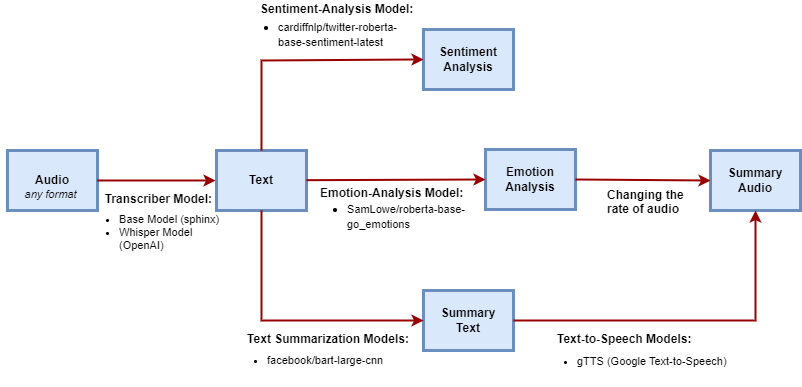

###Audio-to-Text Transcript
Audio-to-text conversion is the crucial initial step in our summarization process. We aim to transcribe spoken content from recorded audio with high accuracy, considering accents, speed, and background noise. We used two methods: CMU Sphinx, chosen for its resilience in offline settings, and OpenAI Whisper, a state-of-the-art deep-learning model. While Sphinx is reliable offline, it may struggle with intricate terminology or noisy backdrops. Whisper excels in precise transcription from diverse audio sources, even with ambient noise or multiple speakers.

In [4]:
def transcribe_audio_sphinx(file_path):
    """ Transcribe audio using Sphinx through SpeechRecognition. """
    text = "Model was not able to read the audio"  # Default text if transcription fails
    r = sr.Recognizer()  # Create a recognizer instance
    with sr.AudioFile(file_path) as source:
        audio = r.record(source)  # Read the entire audio file
    try:
        text = r.recognize_sphinx(audio)  # Attempt to transcribe audio using Sphinx
        return text
    except sr.UnknownValueError:
        print("Sphinx could not understand audio")  # Error if audio is unintelligible
        return text
    except sr.RequestError as e:
        print(f"Sphinx error; {e}")  # Handle other errors from Sphinx
        return text
    return text

In [5]:
def transcribe_audio_whisper(audio_path):
    """ Transcribe audio using OpenAI's Whisper model. """
    model = whisper.load_model("small")  # Load the small Whisper model
    result = model.transcribe(audio_path)  # Perform transcription of the audio file
    return result["text"]  # Return the transcribed text

###Sentiment Analysis for Transcript
We employed two pre-trained models from HuggingFace to analyze text sentiment:
1. Sentiment Analysis:

  We used the ```cardiffnlp/twitter-roberta-base-sentiment-latest``` model to identify the overall sentiment (positive, negative, or neutral) expressed in a piece of text.
2. Emotion Detection:
  
  We then employed the ```SamLowe/roberta-base-go_emotions``` model to uncover the specific emotions (e.g., joy, anger, sadness) present within the text.

In [6]:
# Initialize tokenizer and sentiment analysis tools from Hugging Face's transformers
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
sentiment_analyzer = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Reinitialize tokenizer for a different model focused on emotions
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
emotion_analyzer = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions")

def sentiment_chunk_text(text, max_length):
    """ Split text into manageable chunks for sentiment analysis. """
    token_ids = tokenizer.encode(text, add_special_tokens=True)  # Tokenize text including special tokens
    num_chunks = len(token_ids) // max_length + (1 if len(token_ids) % max_length != 0 else 0)
    chunks = [tokenizer.decode(token_ids[i * max_length: min((i + 1) * max_length, len(token_ids))]) for i in range(num_chunks)]
    return chunks

def aggregate_sentiments(results):
    """ Aggregate sentiment scores from multiple chunks. """
    sentiment_scores = {}
    for result in results:
        label = result[0]['label']
        score = result[0]['score']
        if label in sentiment_scores:
            sentiment_scores[label].append(score)
        else:
            sentiment_scores[label] = [score]
    most_frequent_sentiment = max(sentiment_scores, key=lambda x: len(sentiment_scores[x]))
    average_score = sum(sentiment_scores[most_frequent_sentiment]) / len(sentiment_scores[most_frequent_sentiment])
    return most_frequent_sentiment, average_score

def emotion_chunk_text(text, max_length):
    """ Split text into chunks that fit emotion analysis model's token limit. """
    tokens = tokenizer.tokenize(text)
    num_chunks = len(tokens) // max_length + (1 if len(tokens) % max_length else 0)
    chunks = [tokenizer.convert_tokens_to_string(tokens[i * max_length:(i + 1) * max_length]) for i in range(num_chunks)]
    return chunks

def aggregate_emotions(results):
    """ Aggregate emotion detection results. """
    emotion_counts = {}
    for result in results:
        for res in result:
            label = res['label']
            score = res['score']
            if label in emotion_counts:
                emotion_counts[label].append(score)
            else:
                emotion_counts[label] = [score]
    most_frequent_emotion = max(emotion_counts, key=lambda x: len(emotion_counts[x]))
    average_score = sum(emotion_counts[most_frequent_emotion]) / len(emotion_counts[most_frequent_emotion])
    return most_frequent_emotion, average_score

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [7]:
def analyze_sentiment_and_emotion(transcript):
    """ Analyze sentiment and emotion from a given transcript. """
    if transcript:
        # Divide the transcript into chunks for sentiment analysis
        chunks = sentiment_chunk_text(transcript, 500)  # Use 500 tokens limit to accommodate special tokens
        results = []
        for chunk in chunks:
            result = sentiment_analyzer(chunk)  # Perform sentiment analysis on each chunk
            results.append(result)
        print("Stage (2/5) : Sentiment Analysis")
        final_sentiment, sentiment_score = aggregate_sentiments(results)  # Aggregate results to get overall sentiment
        print(".\n.\n----- Sentiment Analysis Completed -----")

        # Repeat the process for emotion analysis
        chunks = emotion_chunk_text(transcript, 500)
        results = [emotion_analyzer(chunk) for chunk in chunks]  # Perform emotion analysis on each chunk
        print("Stage (3/5) : Emotion Analysis")
        final_emotion, emotion_score = aggregate_emotions(results)  # Aggregate results to get overall emotion
        print(".\n.\n----- Emotion Analysis Completed -----")
    else:
        print("We have faced an Error")
        final_sentiment = "No transcript available"
        sentiment_score = 0
        final_emotion = "No transcript available"
        emotion_score = 0
    return final_sentiment, sentiment_score, final_emotion, emotion_score

###Text Summarization
The objective here is to extract the principal idea of the audio from its transcription by utilizing the ```bart-large-cnn model```, which can handle up to 1024 tokens simultaneously. This methodology facilitates the generation of a summary of a substantial text corpus in a time-efficient manner, by eliminating redundant information and reducing the time required for audience comprehension. In essence, the entire input text was divided into multiple chunks and then summarized by the summarizer, with the summaries of each chunk being joined to form a full summary of the whole input.

Additionally, there are other transformer models that can be employed for text summarization. However, the ```bart-large-cnn``` model has been observed to produce summaries with fewer spelling and grammar mistakes than  ```google-t5-base``` and ```pegasus```, making it a more reliable choice for generating high-quality summaries.


In [8]:
# Set up the tokenizer and summarizer using BART from Facebook's model collection
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
summarizer = pipeline('summarization', model='facebook/bart-large-cnn')

def summary_chunk_text(text, max_length):
    """ Splits the text into chunks that fit the token limit of the summarizer. """
    token_ids = tokenizer.encode(text, add_special_tokens=True)  # Tokenize the text including special tokens
    max_length -= 2  # Adjust for special tokens at the start and end
    num_chunks = len(token_ids) // max_length + (1 if len(token_ids) % max_length != 0 else 0)
    chunks = [
        tokenizer.decode(token_ids[i * max_length: min((i + 1) * max_length, len(token_ids))])
        for i in range(num_chunks)  # Decode each chunk back into text
    ]
    return chunks

def summarize_text(text, chunk_max_length, min_length, max_length):
    """ Summarizes the text using the summarizer model, handling token limits per chunk. """
    chunks = summary_chunk_text(text, chunk_max_length)  # Split text into manageable chunks
    if chunks:  # Ensure there are chunks before dividing
        max_length_per_chunk = max_length // len(chunks)  # Calculate max length for each chunk based on the number of chunks
    else:
        max_length_per_chunk = max_length  # If no chunks, the max length remains unchanged
    min_length_per_chunk=max_length_per_chunk
    summarized_text = []
    for chunk in chunks:
        summary = summarizer(chunk, min_length=min_length_per_chunk, max_length=max_length_per_chunk, truncation=True)  # Summarize each chunk
        summarized_text.append(summary[0]['summary_text'])  # Collect the summaries
    return " ".join(summarized_text)  # Combine all summaries into one text

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

###Text-to-Speech Audio
In this stage, our goal is to convert the summarized text into audio again. This step essentially allows more extensive application and accessibility of the summary for a larger audience. We employed Google Text-to-Speech (gTTS) to generate MP3 audio files containing the spoken version of the input text, which is the summarized text. While more advanced text-to-speech options exist, gTTS excels in its simplicity and affordability, making it a great choice for quick and convenient audio generation.

We tried gTTS with and without adjustments in parameters such as speaking rate, loudness, and pitch shift according to different emotion labels identified in the earlier stages, aiming at preserving the emotion information in the original audio file via this modification.

In [9]:
def text_to_speech_gtts(text, emotion,method):
    rate = 1.0  # Default speech rate
    loudness = 0  # Default loudness (dB)
    pitch_shift = 0  # Default pitch shift (semi-tones)

        # Emotional impact on audio properties
    if emotion in ['sadness', 'grief']:
        rate = 0.9  # Very slow for sadness and grief
        loudness = -2  # Very quiet for sadness and grief
        pitch_shift = 0  # Lower pitch for sadness and grief
    elif emotion == 'disappointment':
        rate = 0.85  # Slower for disappointment
        loudness = -2  # Quieter for disappointment
        pitch_shift = 0  # Lower pitch for disappointment
    elif emotion in ['anger', 'annoyance']:
        rate = 1.15  # Faster for anger and annoyance
        loudness = 3  # Louder for anger and annoyance
        pitch_shift = 1  # Higher pitch for anger and annoyance
    elif emotion == 'disgust':
        rate = 1.0  # Normal rate for disgust
        loudness = -1  # Slightly quieter for disgust
        pitch_shift = 1  # Lower pitch for disgust
    elif emotion in ['joy', 'amusement', 'gratitude']:
        rate = 1.1  # Slightly faster for positive emotions
        loudness = 2  # Slightly louder for positive emotions
        pitch_shift = 1  # Slightly higher pitch for positive emotions
    elif emotion == 'love':
        rate = 0.8  # Slower for love
        loudness = 1  # Slightly louder for love
        pitch_shift = 0  # No pitch shift for love
    elif emotion == 'excitement':
        rate = 1.2  # Faster for excitement
        loudness = 4  # Louder for excitement
        pitch_shift = 1  # Higher pitch for excitement
    elif emotion in ['fear', 'nervousness']:
        rate = 1.1  # Slightly faster for fear and nervousness
        loudness = -1  # Slightly quieter for fear and nervousness
        pitch_shift = 0  # Higher pitch for fear and nervousness
    elif emotion in ['surprise', 'realization']:
        rate = 1.2  # Faster for surprise and realization
        loudness = 2  # Slightly louder for surprise and realization
        pitch_shift = 2  # Higher pitch for surprise and realization
    elif emotion in ['curiosity', 'confusion']:
        rate = 1.05  # Slower for curiosity and confusion
        loudness = -1  # Slightly quieter for curiosity and confusion
        pitch_shift = -1  # Lower pitch for curiosity and confusion
    elif emotion in ['relief', 'remorse', 'approval', 'pride', 'admiration']:
        rate = 1.05  # Normal rate for complex emotions
        loudness = 1  # Slightly louder for complex emotions
        pitch_shift = 1  # Slightly higher pitch for complex emotions

    # Generate speech using gTTS
    tts = gTTS(text=text, lang='en', tld='com')
    base_filename = f"{method}_base.mp3"
    tts.save(base_filename)

    # Load the base audio file
    base_audio = AudioSegment.from_file(base_filename)

    # Create the "without emotions" audio
    without_emotions_filename = f"{method}_without_emotions.mp3"
    base_audio.export(without_emotions_filename, format="mp3")

    adjusted_audio = AudioSegment.empty()
    for chunk in tqdm(base_audio[::1000], desc="Adjusting audio"):
        adjusted_chunk = chunk._spawn(chunk.raw_data, overrides={
            "frame_rate": int(chunk.frame_rate * rate),
            "loudness": loudness,
            "pitch_shift": pitch_shift
        })

        adjusted_audio += adjusted_chunk

    # Save the "with emotions" audio
    with_emotions_filename = f"{method}_with_emotions.mp3"
    adjusted_audio.export(with_emotions_filename, format="mp3")

    # Clean up temporary file
    os.remove(base_filename)

    # Return the audio for playback
    return Audio(with_emotions_filename, autoplay=False),Audio(without_emotions_filename, autoplay=False)

In [10]:
def process_audio_file(file_path, method):
    """Process an audio file using a specified transcription method and analyze sentiment and emotion."""
    print('Stage (1/5) : Transcript Generation')
    # Select the transcription method based on the provided 'method' argument
    if method == 'whisper':
        transcript = transcribe_audio_whisper(file_path)  # Use Whisper for transcription if selected
    else:
        transcript = transcribe_audio_sphinx(file_path)  # Use Sphinx by default
    print('.\n.\n----- Transcript Generation Completed -----')

    # Analyze the sentiment and emotion from the transcript
    sentiment, sentiment_score, emotion, emotion_score = analyze_sentiment_and_emotion(transcript)
    print('Stage (4/5) : Audio Summarization Initiated')
    print("With current GPU(T4) Resource the average execution time is 15-20min")

    # Calculate parameters for summarization
    input_length = len(tokenizer.encode(transcript))  # Encode the transcript to determine its length
    summary_length = max(50, int(input_length / 6))  # Determine the summary length based on input length

    # Summarize the transcript
    final_summary = summarize_text(transcript, 1000, min_length=summary_length, max_length=summary_length)
    print('.\n.\n----- Summarization Completed ------')
    # Return all the results
    return transcript, sentiment, sentiment_score, emotion, emotion_score, final_summary

###Model Evaluation
We evaluate the model performance below with audio file 'Angry.mp3' as the input data.

####Basic Model Evaluation

In [11]:
def runBasicModel(filePath):
    """Executes a basic audio processing model using Sphinx for transcription."""
    # Process the audio file using the Sphinx method
    transcript_sphinx, sentiment_sphinx, sentiment_sphinx_score, emotion_sphinx, emotion_sphinx_score, summarizedText = process_audio_file(filePath, method='sphinx')
    print("Using Sphinx:")
    print("Transcript:", transcript_sphinx)
    # Output the results of sentiment and emotion analysis
    print(f"Sentiment: {sentiment_sphinx}, Score: {sentiment_sphinx_score:.2f}")
    print(f"Emotion: {emotion_sphinx}, Score: {emotion_sphinx_score:.2f}")
    print("Summarized Text:", summarizedText)
    print("Stage (5/5) : Processing Text to Audio")

    # Convert the summarized text to speech with and without emotional tones
    audio_output1, audio_output2 = text_to_speech_gtts(summarizedText, emotion_sphinx, "Basic")
    print("----- Text to Audio Completed -----")
    print("Audio with Emotions : ")
    display(audio_output1)
    print("Audio without Emotions : ")
    display(audio_output2)

# Code for handling file uploads in a Jupyter environment
uploaded = files.upload()
file_path_sphinx = list(uploaded.keys())[0]

# Check and convert the file to WAV format if necessary
if not file_path_sphinx.endswith('.wav'):
    file_path_sphinx1 = convert_to_wav(file_path_sphinx)

# Process the audio file using the basic model
runBasicModel(file_path_sphinx1)

Saving Angry.mp3 to Angry.mp3
Stage (1/5) : Transcript Generation
.
.
----- Transcript Generation Completed -----
Stage (2/5) : Sentiment Analysis
.
.
----- Sentiment Analysis Completed -----


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Stage (3/5) : Emotion Analysis
.
.
----- Emotion Analysis Completed -----
Stage (4/5) : Audio Summarization Initiated
With current GPU(T4) Resource the average execution time is 15-20min
.
.
----- Summarization Completed ------
Using Sphinx:
Transcript: you'd be so much like a father of black and hermida my law team coherence and i think we're acting like him you're exactly like your mother everything and what about richard you would you stop getting in that wall and i want my mother he was a wonderful light heavyweight only had a cat et i caught my locker or i thought or i'm not i'm not at all as your life what are your also like my mother you're all of that is a row of is legal but mostly your mother we would lie in bed together sometimes out of the woods you're just go hopes how a thing you've got yours lot by all the holy will have that new life behind your life cannot intervene and an ally where you think you've got something or has it gotten the the new few years you relative to 

Adjusting audio: 26it [00:00, 3097.89it/s]


----- Text to Audio Completed -----
Audio with Emotions : 


Audio without Emotions : 


As can be seen in the above output, the basic model using Sphinx as the transcriber resulted in numerous inaccuracies and omitted punctuation, presenting the transcript as a lengthy, disjointed sentence. Crucial contextual cues, such as identifying the audio as a conversation between two individuals, were lost.

For sentiment analysis, since it was based on a poorly transcribed output, the anger emotion in the input audio could not be captured successfully (with sentiment being recognized as positive and emotion neutral). The summary was incomplete due to the maximum length settings of the model. Also, the summarized output largely repeated the first few sentences, perhaps because the messy transcript did not make sence semantically.

Since the sentiment and emotion were not identified correctly and the transcription and and summary were poorly performanced, the final text-to-speech output yielded no difference for parameter adjustments. gTTS correctly read the input summary, yet the output was still not realistic enough due limitations such as voice (speaker) selection, which again lost the conversation nature of the original audio.

####Advanced Model Evaluation

In [12]:
def runAdvanceModels(filePath):
    """Executes an advanced audio processing model using OpenAI's Whisper for transcription."""
    # Process the audio file using the Whisper method for more accurate and advanced transcription
    transcript_whisper, sentiment_whisper, sentiment_whisper_score, emotion_whisper, emotion_whisper_score, summarizedText = process_audio_file(filePath, method='whisper')
    print("Using Whisper:")
    print("Transcript:", transcript_whisper)
    # Display the results of sentiment and emotion analysis
    print(f"Sentiment: {sentiment_whisper}, Score: {sentiment_whisper_score:.2f}")
    print(f"Emotion: {emotion_whisper}, Score: {emotion_whisper_score:.2f}")
    print("Summarized Text:", summarizedText)
    print("Stage (5/5) : Processing Text to Audio")

    # Convert the summarized text to speech with and without emotional tones
    audio_output1, audio_output2 = text_to_speech_gtts(summarizedText, emotion_whisper, "Advance")
    print("----- Text to Audio Completed -----")
    print("Audio with Emotions : ")
    display(audio_output1)
    print("Audio without Emotions : ")
    display(audio_output2)

# Code for handling file uploads in a Jupyter environment
uploaded = files.upload()
file_path_whisper = list(uploaded.keys())[0]

# Process the audio file using the advanced model
runAdvanceModels(file_path_whisper)

Saving Angry.mp3 to Angry (1).mp3
Stage (1/5) : Transcript Generation


100%|███████████████████████████████████████| 461M/461M [00:05<00:00, 92.0MiB/s]


.
.
----- Transcript Generation Completed -----
Stage (2/5) : Sentiment Analysis
.
.
----- Sentiment Analysis Completed -----
Stage (3/5) : Emotion Analysis
.
.
----- Emotion Analysis Completed -----
Stage (4/5) : Audio Summarization Initiated
With current GPU(T4) Resource the average execution time is 15-20min
.
.
----- Summarization Completed ------
Using Whisper:
Transcript:  You're being so much like your father. Do not compare me to my father. I didn't compare you to him. I said you were acting like him. You're exactly like your mother. Everything you're complaining about her, you're doing. You're suffocating Henry. First of all, I love my mother. She was a wonderful mother. Just forbidding what you told me. Secondly, how dare you compare my mother into my mother? I may be like my father, but I am not like my mother. You are! And you're like my father. You're also like my mother. You're all the bad things about all of these people. But mostly your mother. When we would lie in bed 

Adjusting audio: 35it [00:00, 3685.68it/s]


----- Text to Audio Completed -----
Audio with Emotions : 


Audio without Emotions : 


With the use of OpenAI Whisper as our transcriber, the content of the input audio, even segments with overlapping speech were accurately transcribed with proper punctuation. Sentiment analysis successfully identified negative emotions, particularly anger, with scores of 0.76 and 0.36 respectively. However, the conversational context was not preserved in the transcription.

The summarized text seemed to try capturing the core messages in each chunk instead of simply repeating sentences in the same order as the transcript; proper punctuation marks were used as well in the summary and the conversational nature was captured by terms like 'she said' and 'she added'. Again, the summary was incomplete due to the maximum length settings of the model.

For text-to-speech audio, the audio output with emotions, compared to the one without emotions, was of higher speaking rate, volume, and pitch, reflecting the adjustment we made to simulate anger in speeches. However, the limitations mentioned above still existed. More advanced text-to-speech models might be considered if greater control and more natural-sounding voices are needed.


##Limitations and Recommendations
While we acknowledge that the end-to-end process of the audio-to-audio project shares the desired output, some limitations still exist. Following is the breakdown of the limitations/challenges for this project.
  
* Pre-trained models may struggle with out-of-vocabulary words or rare words that were not present in the training data.

* Pre-trained models are trained on vast amounts of text data from the internet; therefore, they may contain biases or skewed representations of certain topics.  These biases can propagate through the model's predictions and affect downstream applications.

* The model processing limit of 512 tokens necessitated splitting longer texts into smaller chunks for analysis.

* Google Collab provides limited GPU processing power to develop a training model. Therefore, for this project, pre-trained models were incorporated to avoid any significant computational burden.  

* Emotion Analysis is restricted to a limited predefined set of emotions defined by the GoEmotions dataset, which restricts the performance based on the input text.

* gTTS lacks control over finer, realistic voice characteristics like emotion.

Optimize performance by balancing model complexity with computational resources. Fine-tune sentiment models for domain-specific comprehension. Improve summarization models for fluency. Ensure smooth integration of audio-to-text and text-to-audio methods. Continuously evaluate and adapt the pipeline for enhanced user experience and efficiency.

##Conclusion
The integration of audio-to-text, sentiment analysis, text summarization, and text-to-audio conversion presented the project's breadth in text analytics. Leveraging advanced models like OpenAI Whisper and sentiment analysis and summarization models, we achieved desired accuracy. Despite initial challenges with Sphinx, OpenAI Whisper excelled in accurate transcription and sentiment detection. Text summarization employing bart-large-cnn provided concise summaries, however with length limitations. Furthermore, gTTS served as a reliable choice for text-to-audio conversion. Overall, this project emphasises the potential of advanced models in enhancing text analytics workflows while highlighting areas for future refinement.

##References
* A. Vartakavi, A. Garg and Z. Rafii, "Audio Summarization for Podcasts," 2021 29th European Signal Processing Conference (EUSIPCO), Dublin, Ireland, 2021, pp. 431-435, doi: 10.23919/EUSIPCO54536.2021.9615948.  


* Vishal Gupta, Gurpreet Singh Lehal. A survey of Text summarization techniques , Journal of Emerging Technologies in Web Intelligence VOL 2 NO 3 ;August 2010.

* Cut. Teachers React to Heartfelt Letters from Their Students | Cut. https://www.youtube.com/watch?v=0sfdDHlrHf4&t=60s.

* Louis Teitelbaum. 911 Recordings. https://www.kaggle.com/datasets/louisteitelbaum/911-recordings/data.

* Netflix. Scarlett Johansson and Adam Driver in Marriage Story l Netflix. https://www.youtube.com/watch?v=FDFdroN7d0w.

* OpenAI. (n.d.). Whisper: A sequence-to-sequence model for audio transcription. Retrieved from https://github.com/openai/whisper?tab=readme-ov-file

* Hugging Face. (n.d.). BART (facebook/bart-large-cnn). Retrieved from https://huggingface.co/facebook/bart-large-cnn

  
* Hugging Face. (n.d.). T5 (google-t5/t5-base). Retrieved from https://huggingface.co/google-t5/t5-base

  
* Hugging Face. (n.d.). Pegasus (google/pegasus-cnn_dailymail). Retrieved from https://huggingface.co/google/pegasus-cnn_dailymail

* Malheiro, R. and  Paiva, R.P. Audio Features for Music Emotion Recognition: A Survey.